In [1]:
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [3]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


def to_dataframe(json_data):
    df = pd.DataFrame(json_data, columns=['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'])
    df.drop(columns=['CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'], inplace=True)
    df['OpenTime'] = pd.to_datetime(df['OpenTime'], unit='ms')
    df.set_index(keys=['OpenTime'], inplace=True)

    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32')

    return df


def get_klines(base_url, symbol, interval='1m'):
    end_time = int(datetime.utcnow().timestamp() * 1000)
    url = f"{base_url}/klines?symbol={symbol}&limit=1000&interval={interval}&endTime={end_time}"

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("GET", url, headers=headers)

    df = to_dataframe(response.json())
    return df


def get_futures_data(symbol, interval='1m'):
    # 
    return get_klines('https://fapi.binance.com/fapi/v1', symbol, interval=interval)



def get_coinm_data(symbol, interval='1m'):
    # 
    return get_klines('https://dapi.binance.com/dapi/v1', symbol, interval=interval)


def get_spot_data(symbol, interval='1m'):
    return get_klines('https://api.binance.com/api/v3', symbol, interval=interval)


In [12]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 'LUNA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'UST', 'MATIC', 'CRO', 'WBTC', 'DAI', 'ATOM', 'LTC', 'LINK']
symbols = [f'{s}USDT' for s in symbols]

data = []

for symbol in symbols:
    df = get_futures_data(symbol=symbol, interval='1h')

    df.rename(columns={'Close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    data.append(np.log(df[symbol]))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-03-07 16:00:00,10.566776,7.860559,5.933650,-0.301916,-0.187897,4.433670,4.403862,4.307976,2.824351,-2.117850,0.374181,3.368295,4.628301,2.592864
2022-03-07 17:00:00,10.560639,7.851404,5.930413,-0.306661,-0.191039,4.428075,4.401793,4.310262,2.818100,-2.121181,0.365754,3.361035,4.619369,2.584752
2022-03-07 18:00:00,10.544328,7.832593,5.918867,-0.320205,-0.207639,4.416428,4.375719,4.292786,2.804996,-2.136732,0.345503,3.367365,4.602567,2.563025
2022-03-07 19:00:00,10.526445,7.807376,5.900582,-0.340661,-0.242454,4.385396,4.339785,4.261835,2.779006,-2.161086,0.322953,3.312330,4.575123,2.530756
2022-03-07 20:00:00,10.533709,7.810421,5.933041,-0.334494,-0.236482,4.395930,4.332180,4.266335,2.786985,-2.156582,0.329232,3.320024,4.576256,2.525409


In [13]:
df.tail()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT
OpenTime,,,,,,,,,,,,,,
2022-04-18 03:00:00,10.591331,8.004091,6.010801,-0.277732,-0.080993,4.616209,4.363188,4.328098,2.883403,-1.967256,0.298548,3.156234,4.696381,2.624959
2022-04-18 04:00:00,10.566134,7.976152,5.984540,-0.314848,-0.123977,4.558393,4.327966,4.279856,2.846710,-2.008871,0.261133,3.113693,4.661456,2.585431
2022-04-18 05:00:00,10.568501,7.977093,5.984843,-0.309110,-0.121377,4.572957,4.333991,4.285516,2.847812,-2.003963,0.267122,3.118923,4.665418,2.583318
2022-04-18 06:00:00,10.570114,7.977275,5.988636,-0.307069,-0.128515,4.573679,4.341465,4.294015,2.851573,-1.999374,0.274901,3.126146,4.666641,2.586861
2022-04-18 07:00:00,10.568804,7.969420,5.985346,-0.309382,-0.126017,4.568299,4.337840,4.287167,2.846013,-2.004334,0.268117,3.119188,4.662873,2.579838


In [14]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [15]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[47.542706436651244, -80.39289765130849]",ETHUSDT,BNBUSDT
1,"[40.09351270817597, -23.115733503212173]",BNBUSDT,DOGEUSDT
2,"[12.365117026010637, -27.103306007330975]",ADAUSDT,LTCUSDT


In [16]:
coint_df.to_csv('coint_df.csv')


In [17]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df.copy()
        spread = calculate_spread(_df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

In [18]:
stationary_df

,i,pairs,half_life
0,0,"[ETHUSDT, BNBUSDT]",261.544113
2,2,"[ADAUSDT, LTCUSDT]",1313.630784
1,1,"[BNBUSDT, DOGEUSDT]",3467.555002


In [20]:
selected_row = stationary_df[stationary_df['i'] == 0]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df, selected_row, hedge_ratio)
spread = spread.iloc[:500]

0


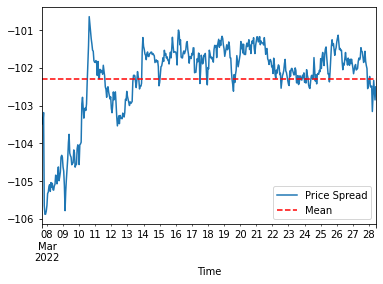

In [21]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

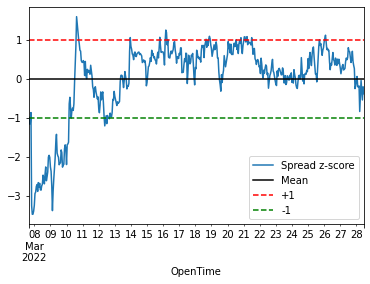

In [23]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])